#**Libraries & Packages**

In [ ]:
# Importing libraries for financial Data Analysis & Time Series Predication
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import plot_model
import numpy as np
import scipy as sp
import tensorflow
import keras
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import metrics

#**Data Loading**

In [ ]:
# Retrieving historical stock data for 'INFY(Infosys)' from Yahoo Finance (Jan 2019 - Jan 2023)
ticker = 'INFY'
data = yf.download(ticker, start="2019-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed


#**Data Preprocessing and Exploratory Data Analysis with Feature Engineering**

In [ ]:
# Sorting & Displaying Key Information in the stock Data: head,columns & tail
data = data.sort_values('Date')
print(data.head())
print(data.columns)
print(data.tail())

            Open  High   Low  Close  Adj Close   Volume
Date                                                   
2019-01-02  9.50  9.73  9.47   9.61   8.491578  9818900
2019-01-03  9.55  9.59  9.47   9.47   8.367872  9404900
2019-01-04  9.52  9.72  9.50   9.63   8.509251  7119000
2019-01-07  9.70  9.81  9.66   9.71   8.579941  7732700
2019-01-08  9.82  9.85  9.72   9.75   8.615285  9391600
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                 Open       High    Low      Close  Adj Close   Volume
Date                                                                  
2022-12-23  17.820000  17.950001  17.73  17.920000  17.453247  3685100
2022-12-27  18.010000  18.090000  17.84  18.030001  17.560383  4943200
2022-12-28  18.049999  18.190001  17.92  17.959999  17.492205  5872100
2022-12-29  18.090000  18.379999  18.09  18.240000  17.764912  4971600
2022-12-30  18.090000  18.180000  17.85  18.010000  17.540903  4468300


In [ ]:
# Checking & Summing up missing values in the stock data
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Displaying information & descriptive statastics for the  stock data
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2019-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1 KB


,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,15.823175,15.962510,15.687282,15.828274,14.832637,9.967296e+06
std,5.160655,5.196915,5.123626,5.162797,5.124557,6.263134e+06
min,6.920000,7.190000,6.760000,6.940000,6.329522,1.320600e+06
25%,10.787500,10.827500,10.680000,10.760000,9.612981,6.101025e+06
50%,16.850000,16.915000,16.655000,16.725000,15.802841,8.416400e+06
75%,19.730000,19.895000,19.595000,19.719999,19.026182,1.206075e+07
max,26.150000,26.389999,25.580000,26.200001,24.964006,7.716540e+07


In [ ]:
# Setting a dark background style for Matplotlib plots
plt.style.use('dark_background')


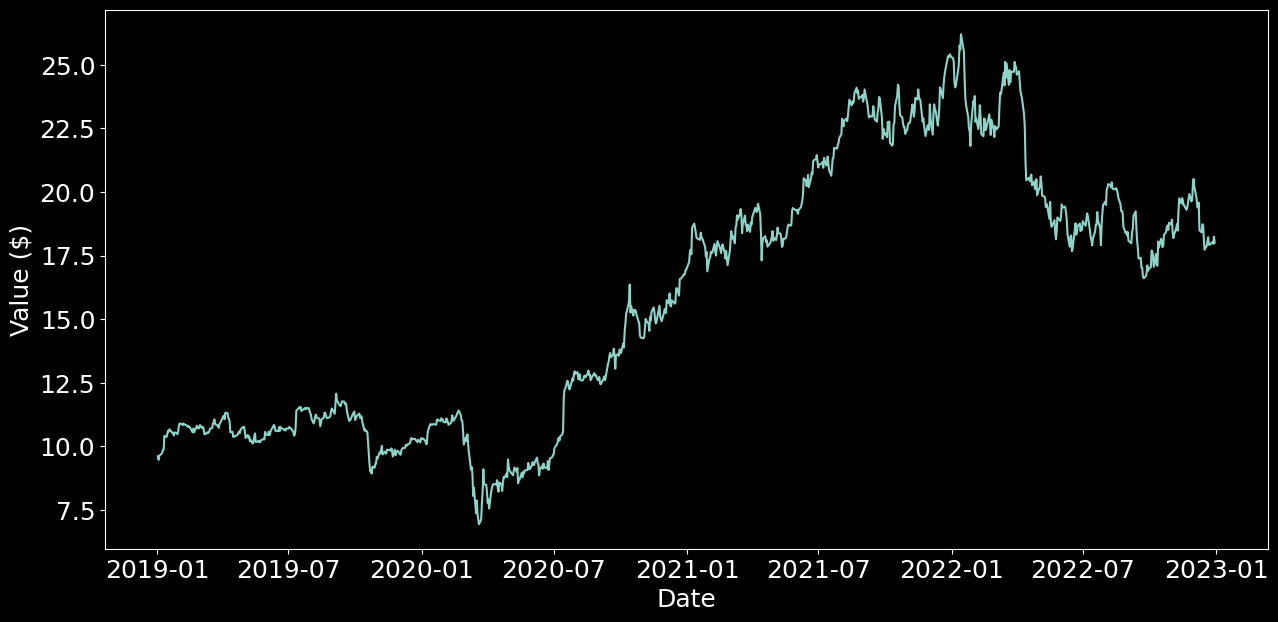

In [ ]:
# Plotting the closing stock prices with custom figure size,axis labels & font size
plt.figure(figsize=(15,7))
plt.plot(data.Close)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.rcParams.update({'font.size': 18})

In [ ]:
# Calculates percentage difference over a specified lag in time series
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

# Exponential Moving Average(EMA) calculations for a time series with
# given window

def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

# Calculates Root Mean Square(RMS) & Mean Absolute Error (MAE)
# between Predicated Values & Actual Values

def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

In [ ]:
# Extract & Clean 'CLOSE' column from the Dataframe
df = data.Close
df = df.dropna(axis=0, how='any')

# Creating a DataFrame with various technical  indicators & features
v_10 = SMA(data.Volume, 10)
v_20 = SMA(data.Volume, 20)
open_close = (data.Close/data.Open - 1).tolist()
high_low = (data.High/data.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = data.Volume.tolist()

# Constructing a DataFrame with calculated indicators & features
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])


# Removing the first 100 rows from the dataframe 'MAs' & resetting the index
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

# Calculating & Adding new feature to the Dataframe 'MAs'
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

<ipython-input-25-2c1420a0111e>:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,10.30,0.006843,13101000,-0.009615,0.014563,0.214469,0.018332,0.005012,-0.003628,-0.031172,-0.027274,-0.031335,-0.027645
1,10.27,-0.002913,9885000,-0.005808,0.010753,-0.116414,-0.235959,0.001620,-0.004169,-0.033175,-0.030839,-0.031500,-0.029127
2,10.57,0.029211,9560600,0.018304,0.022179,-0.129453,-0.262026,0.023853,0.025915,-0.004314,-0.003413,-0.030661,-0.029466
3,10.47,-0.009461,8501000,-0.002857,0.011527,-0.225923,-0.333486,0.010984,0.016702,-0.012860,-0.013548,-0.031732,-0.029077
4,10.45,-0.001910,16517600,-0.010417,0.021134,0.450043,0.370608,0.007027,0.014169,-0.013611,-0.016082,-0.029734,-0.027392


<Figure size 640x480 with 0 Axes>

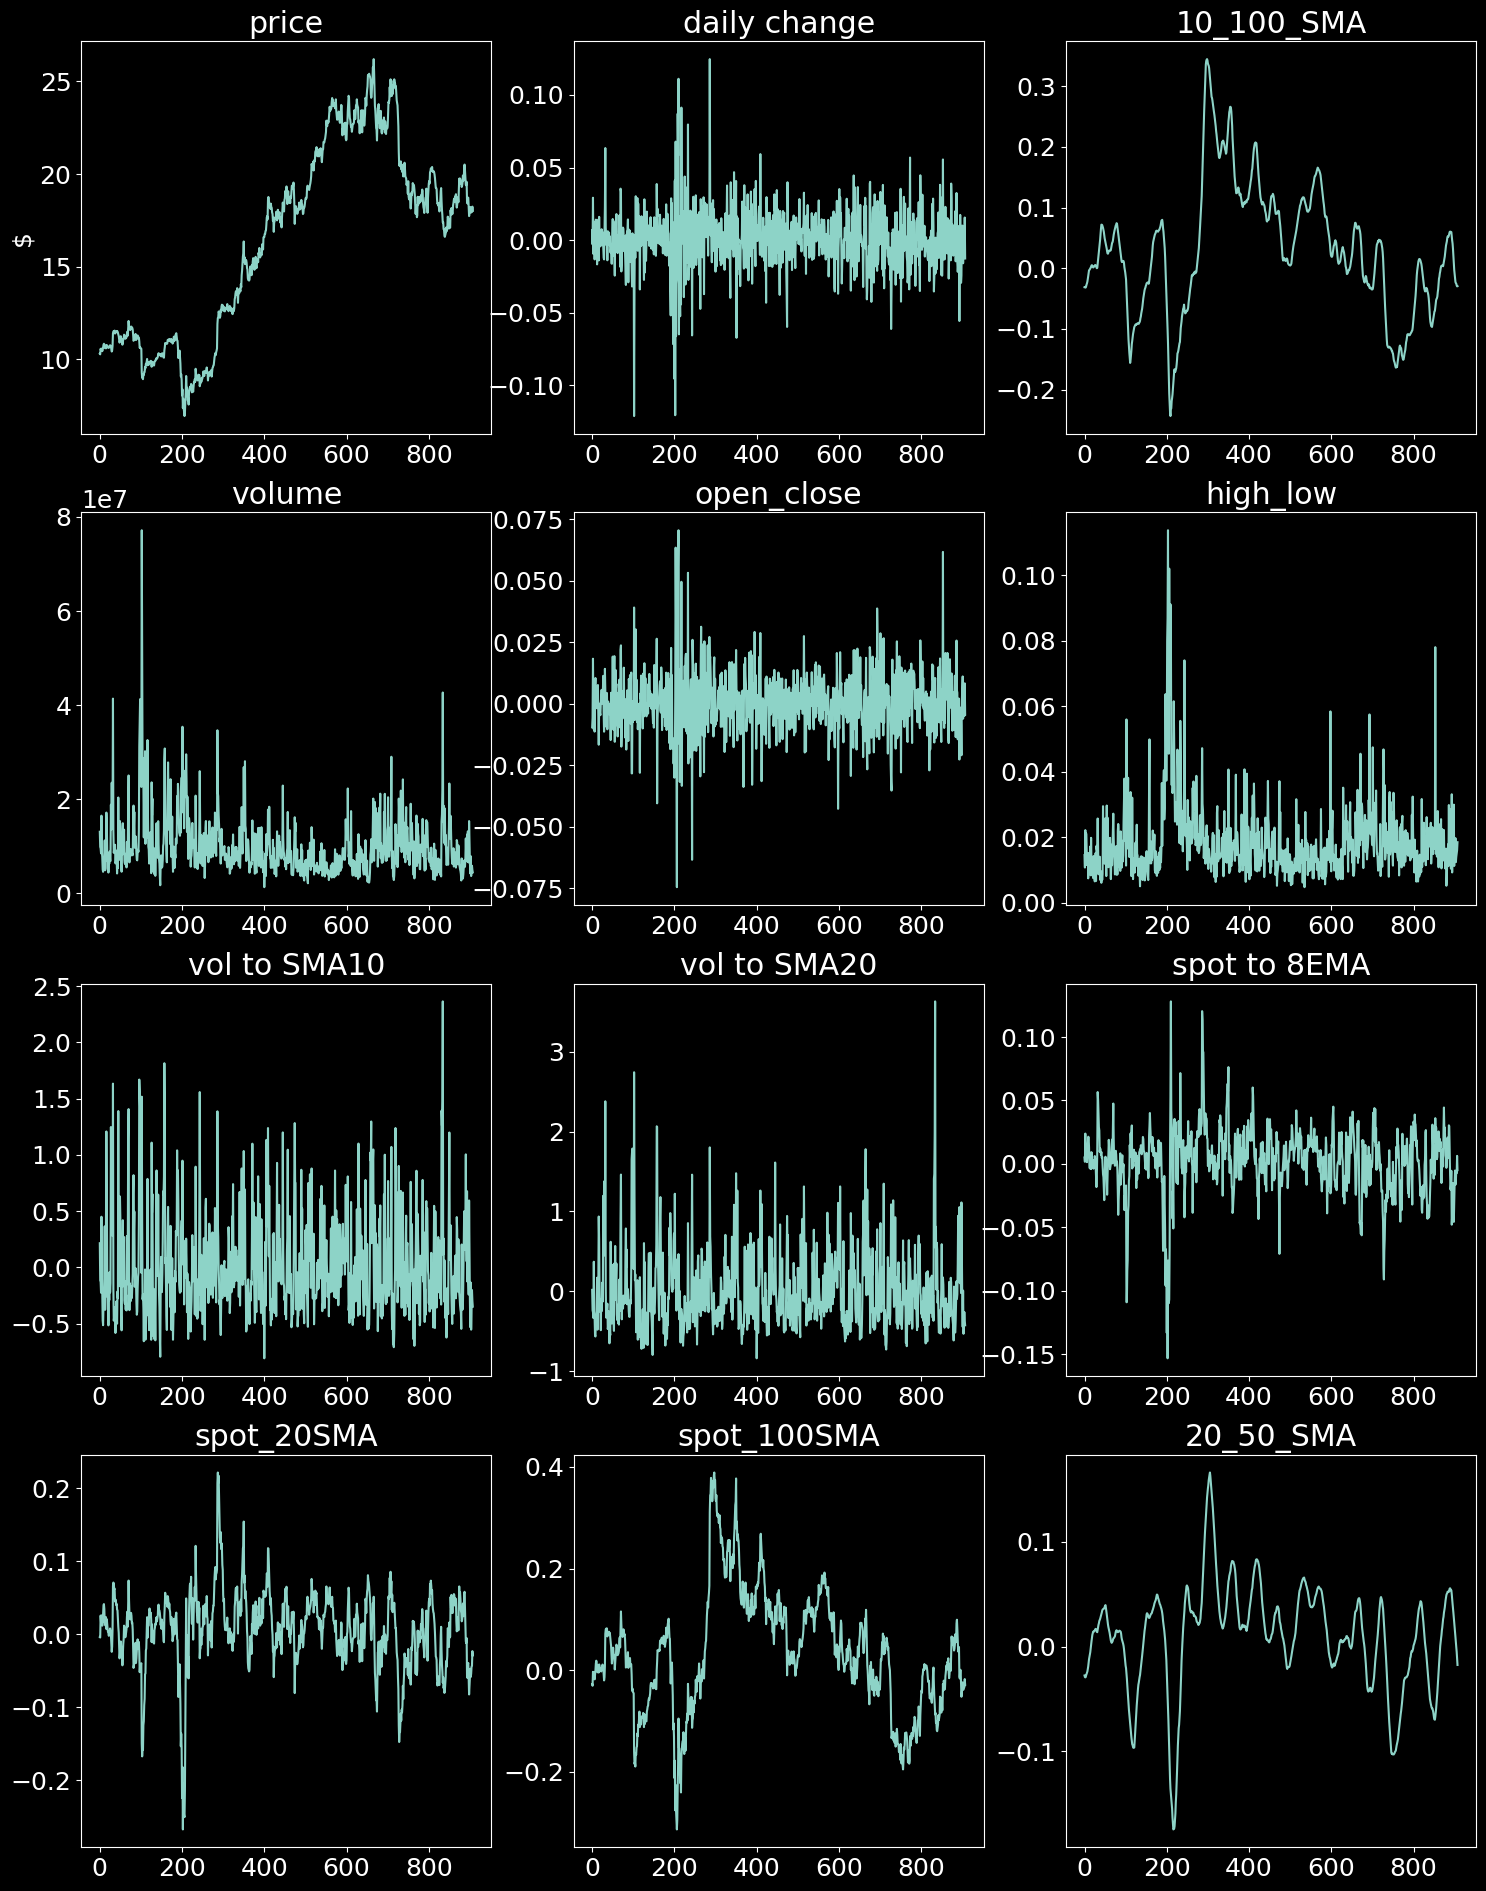

In [ ]:
#Plotting Multiple subplots to visulize selected  features  in the DataFrame 'MAs'

fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')

# Displaying the first 5 rows of the DataFrame 'MAs'
MAs.head(5)


In [ ]:
# Dropping columns at indices 4 & 5 from the Dataframe 'data'
data.drop(data.columns[[4,5]], axis=1, inplace=True)
data.head()

,Open,High,Low,Close
Date,,,,
2019-01-02,9.50,9.73,9.47,9.61
2019-01-03,9.55,9.59,9.47,9.47
2019-01-04,9.52,9.72,9.50,9.63
2019-01-07,9.70,9.81,9.66,9.71
2019-01-08,9.82,9.85,9.72,9.75


In [ ]:
# Scaling selected columns in the  DataFrame 'data' by dividing by 100
data['High'] = data['High'] / 100
data['Open'] = data['Open'] / 100
data['Low'] = data['Low'] / 100
data['Close'] = data['Close'] / 100

# Displaying the head & tail of the modified DataFrame 'data
print(data.head())
print(data.tail())

              Open    High     Low   Close
Date                                      
2019-01-02  0.0950  0.0973  0.0947  0.0961
2019-01-03  0.0955  0.0959  0.0947  0.0947
2019-01-04  0.0952  0.0972  0.0950  0.0963
2019-01-07  0.0970  0.0981  0.0966  0.0971
2019-01-08  0.0982  0.0985  0.0972  0.0975
              Open    High     Low   Close
Date                                      
2022-12-23  0.1782  0.1795  0.1773  0.1792
2022-12-27  0.1801  0.1809  0.1784  0.1803
2022-12-28  0.1805  0.1819  0.1792  0.1796
2022-12-29  0.1809  0.1838  0.1809  0.1824
2022-12-30  0.1809  0.1818  0.1785  0.1801


In [ ]:
# Converting the DataFrame 'data' to a Numpy array 'data_new'
data_new = data.to_numpy()

In [ ]:
# Creating sequences & preparing training & testing data for LSTM model
result = []
sequence_length = 6


# Generating the sequences
for index in range(len(data_new) - sequence_length):
    result.append(data_new[index: index + sequence_length])

result = np.array(result)

# Splitting data into training & testing sets
row = round(0.8 * result.shape[0])

# Creating training data
train = result[:int(row), :]

# Seperating features & target variable
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

amount_of_features = len(data.columns)

# Reshaping data for the input to LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

# Displaying the shapes of the training & testing sets
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (802, 5, 4)
y_train (802,)
X_test (200, 5, 4)
y_test (200,)


#**Model Definition**

In [ ]:
# Importing necessary liabraries for the LSTM Model
import math
import tensorflow as tf
#importing keras modules
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout , Flatten
from keras.layers import LSTM
from keras import losses

In [ ]:
# Building an LSTM model with specified layers & architecture,
# The commented options were part of th regression to reach an optimum value for the model metrics MSE,MAE etc
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import  BatchNormalization
def build_model(layers):
        d = 0.3
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(BatchNormalization())
        #model.add(LSTM(64,return_sequences=False))
        #model.add(LSTM(128,return_sequences=False))
        model.add(LSTM(256,return_sequences=False))
        #model.add(BatchNormalization())
        #model.add(Dropout(d))
        #model.add(Dense(16, activation="relu", kernel_initializer="he_uniform"))
        #model.add(Dense(32, activation="relu", kernel_initializer="he_uniform"))
        model.add(Dense(64, activation="relu", kernel_initializer="he_uniform"))
        #model.add(Dense(64, activation="linear", kernel_initializer="he_uniform"))
        #model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
        #model.add(Dropout(d))
        model.add(Dense(1, activation="linear", kernel_initializer="he_uniform"))
        #model.add(Dropout(d))
        #model.compile(loss='mse',optimizer='adam',metrics=['mae'])

        # Configure the optimizer with learning rate
        from keras.optimizers import Adam
        learning_rate = 0.001
        optimizer = Adam(learning_rate=learning_rate)
        #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

        # Compiling the model with specified loss & metrics
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            68096     
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 478849 (1.83 MB)
Trainable params: 478849 (1.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


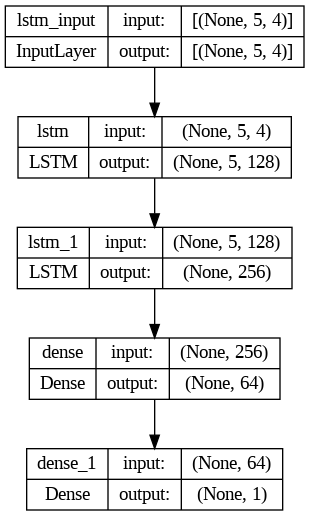

In [ ]:
# Building  the LSTM model with  input shape [4,5,6]
model = build_model([4,5,1])

# Displaying Summary of the Model architecture
print(model.summary())

# Plotting the model architecture & saving it to 'model_plot.png'
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


#Model Training with Callbacks and loss, error graph

In [ ]:
# Training the model with EarlyStopping and ReduceLROnPlateau callbacks
from timeit import default_timer as timer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

start = timer()

# Fitting the model to the training data
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=50,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=[early_stopping
                               #,reduce_lr
                              ]
                    )
end = timer()
print(end - start)

Epoch 1/50
81/81 - 6s - loss: 6.9205e-04 - mae: 0.0144 - val_loss: 5.0668e-05 - val_mae: 0.0055 - 6s/epoch - 75ms/step
Epoch 2/50
81/81 - 0s - loss: 2.7927e-05 - mae: 0.0040 - val_loss: 7.7363e-05 - val_mae: 0.0069 - 462ms/epoch - 6ms/step
Epoch 3/50
81/81 - 1s - loss: 2.7588e-05 - mae: 0.0041 - val_loss: 6.1316e-05 - val_mae: 0.0064 - 646ms/epoch - 8ms/step
Epoch 4/50
81/81 - 1s - loss: 2.1927e-05 - mae: 0.0034 - val_loss: 8.2488e-05 - val_mae: 0.0077 - 698ms/epoch - 9ms/step
Epoch 5/50
81/81 - 1s - loss: 2.3088e-05 - mae: 0.0036 - val_loss: 4.8991e-05 - val_mae: 0.0053 - 623ms/epoch - 8ms/step
Epoch 6/50
81/81 - 1s - loss: 2.1756e-05 - mae: 0.0035 - val_loss: 5.2414e-05 - val_mae: 0.0058 - 637ms/epoch - 8ms/step
Epoch 7/50
81/81 - 1s - loss: 3.2851e-05 - mae: 0.0045 - val_loss: 4.8034e-05 - val_mae: 0.0055 - 649ms/epoch - 8ms/step
Epoch 8/50
81/81 - 1s - loss: 2.3754e-05 - mae: 0.0036 - val_loss: 1.3344e-04 - val_mae: 0.0101 - 574ms/epoch - 7ms/step
Epoch 9/50
81/81 - 0s - loss: 2.16

In [ ]:
# Extracting and visualizing the training history
history_dict = history.history
history_dict.keys()

# Setting the plot style to 'dark_background'
plt.style.use('dark_background')

<ipython-input-37-ab4094df0308>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss',linewidth=3)
<ipython-input-37-ab4094df0308>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values50 , 'b',color='red', label='Validation loss',linewidth=3)


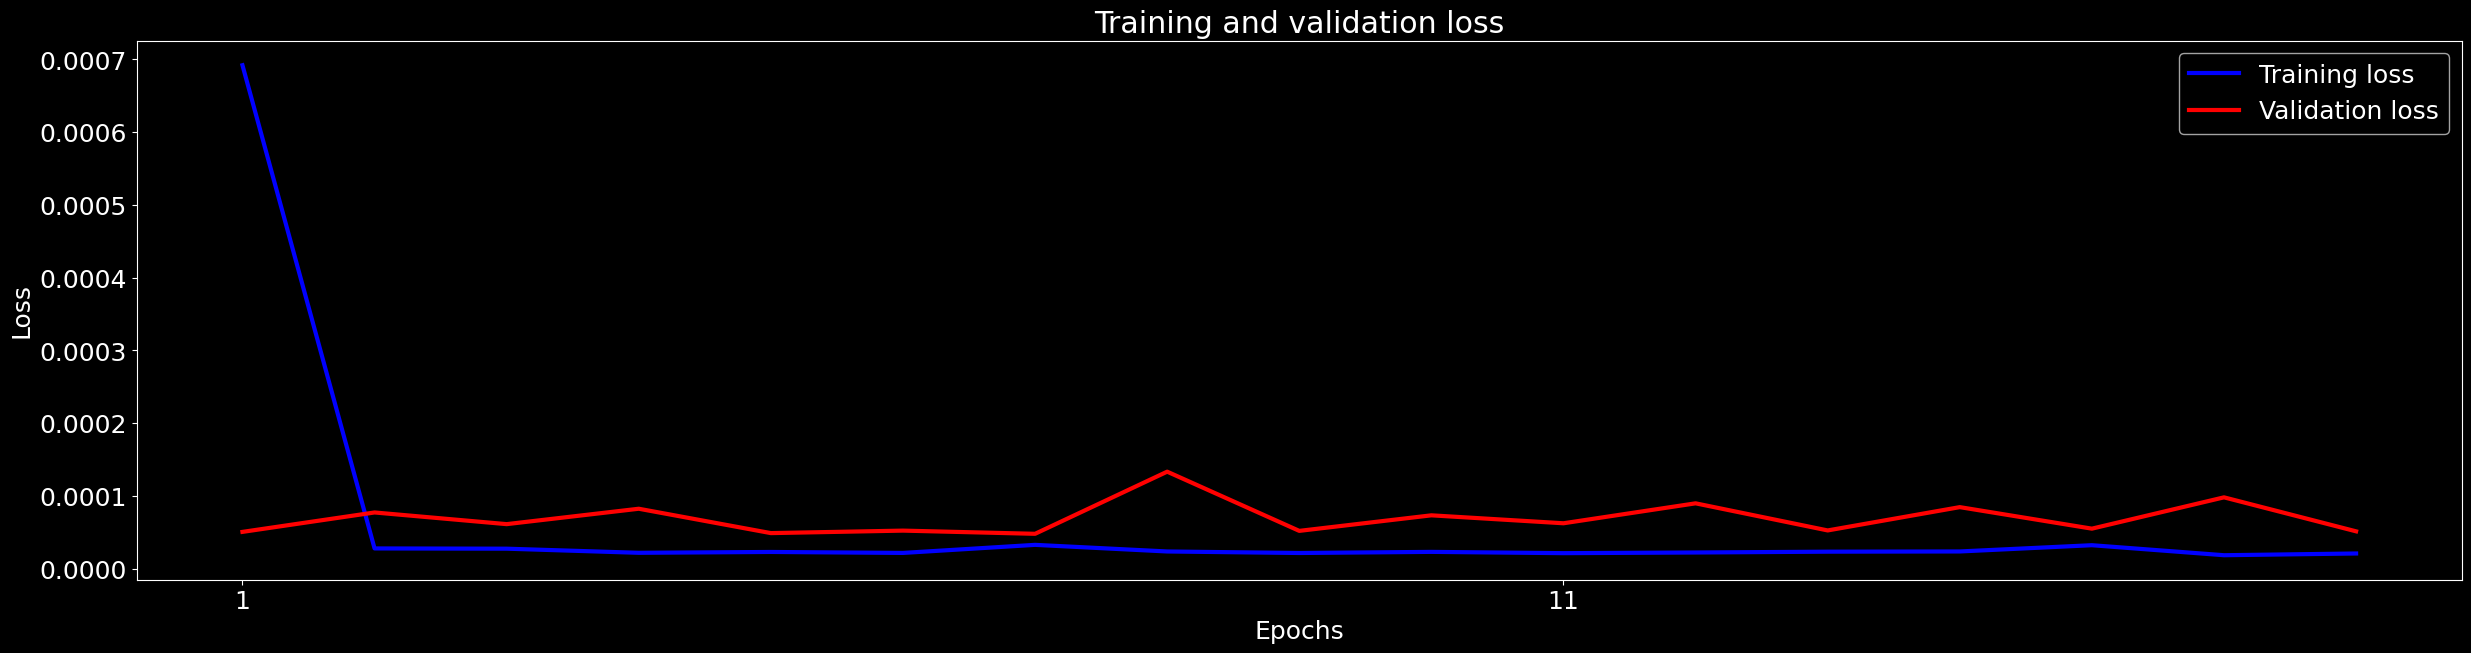

In [ ]:
# Plotting training and validation loss over epochs
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss',linewidth=3)
plt.plot(epochs, val_loss_values50 , 'b',color='red', label='Validation loss',linewidth=3)
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xticks(epochs)

# Setting x-axis ticks at regular intervals
tick_interval = 10
plt.xticks(np.arange(1, len(epochs) + 1, tick_interval))

# Adjusting figure size and displaying the plot
fig = plt.gcf()
fig.set_size_inches(30,7)
#fig.savefig('img/25/mrftest&validationlossconv1dlstm.png', dpi=300)
plt.show()

<ipython-input-39-8794a3a0fca6>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, mae, 'b',color = 'blue', label='Training error',linewidth=3)
<ipython-input-39-8794a3a0fca6>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vmae, 'b',color='red', label='Validation error',linewidth=3)


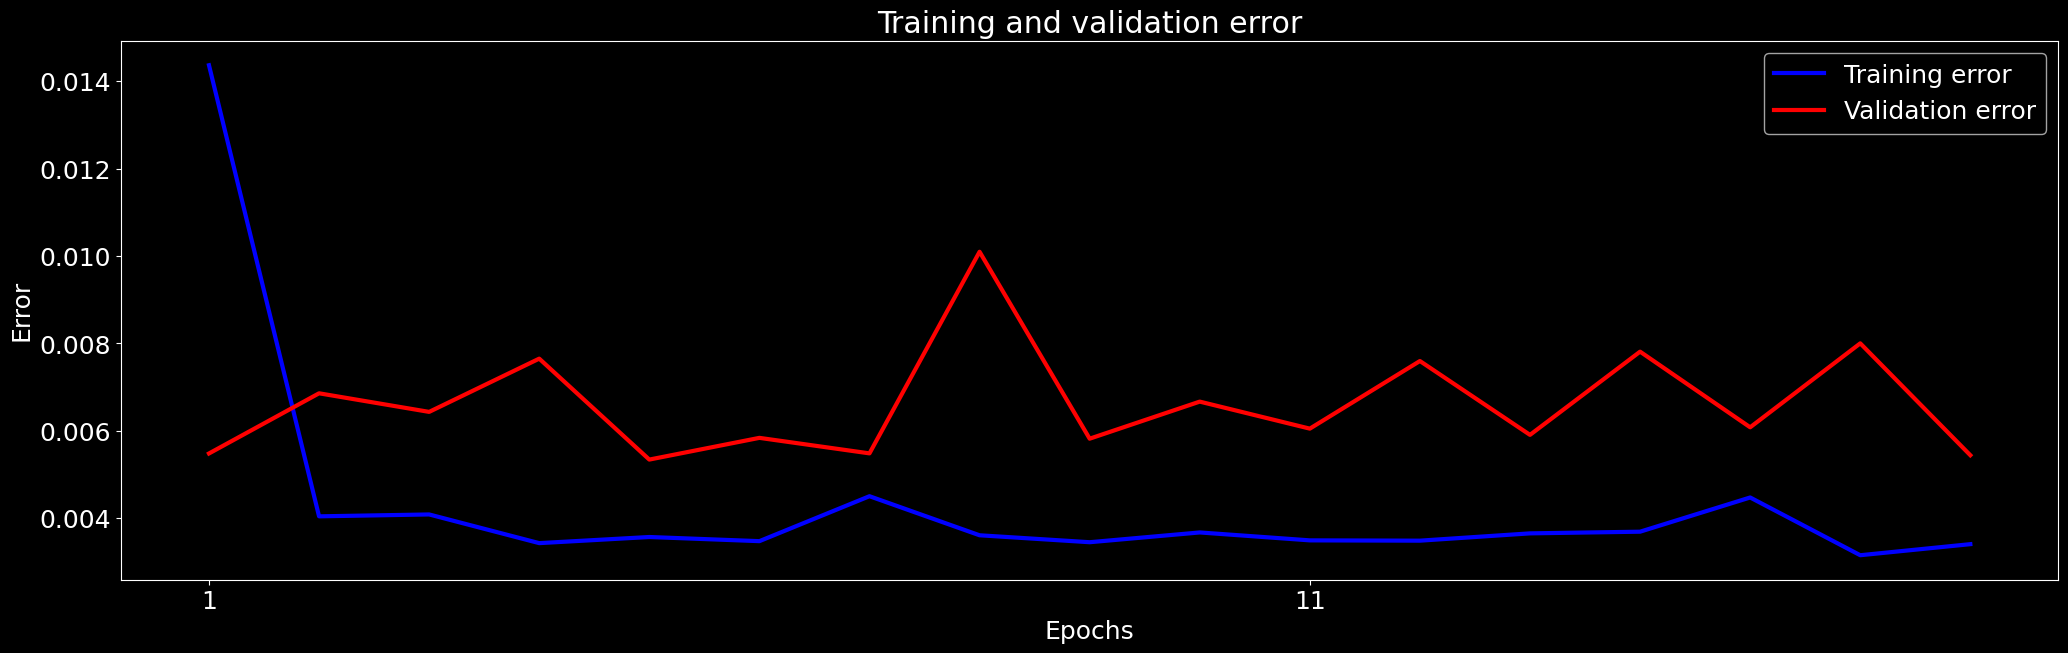

In [ ]:
# Plotting training and validation error over epochs
mae = history_dict['mae']
vmae = history_dict['val_mae']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training error',linewidth=3)
plt.plot(epochs, vmae, 'b',color='red', label='Validation error',linewidth=3)
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
#plt.xticks(epochs)
tick_interval = 10
plt.xticks(np.arange(1, len(epochs) + 1, tick_interval))
fig = plt.gcf()
fig.set_size_inches(25,7)
#fig.savefig('img/25/mrftest&validationerrorconv1dlstm.png', dpi=300)
plt.show()

In [ ]:
# Retrieving the names of the metrics used in the model
model.metrics_names

['loss', 'mae']

#**Model Evaluation**

In [ ]:
# Calculating the model evaluation scores on training and testing sets
trainScore = model.evaluate(x_train, y_train, verbose=0)
testScore = model.evaluate(x_test, y_test, verbose=0)

#**Model Prediction**

In [ ]:
#predicting values for y_test
p = model.predict(x_test)

7/7 [==============================] - 1s 4ms/step


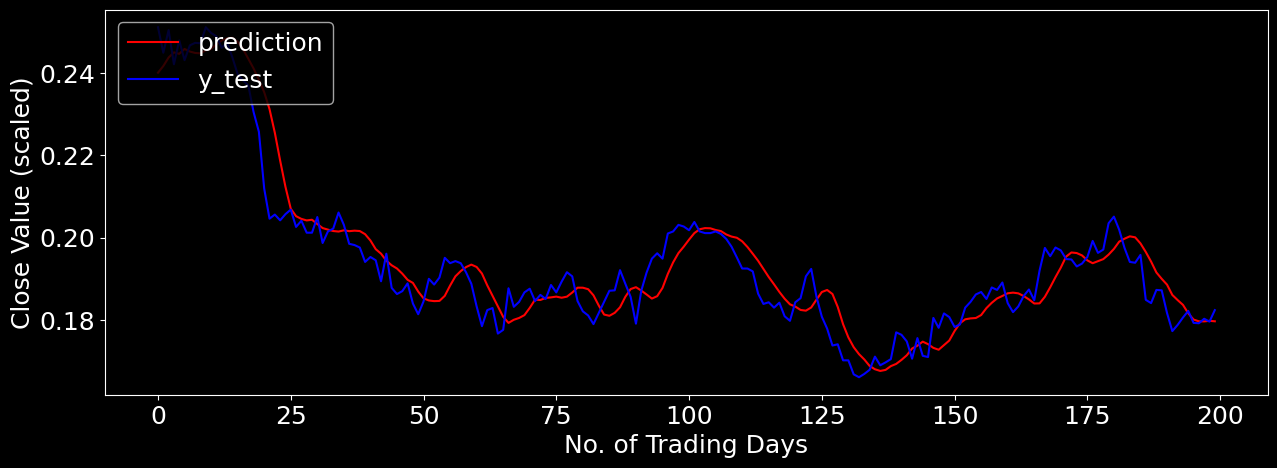

In [ ]:
# Plotting the model predictions and actual values on the test set
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/25/mrftestconv1dlstm.png', dpi=300)
plt.show()

In [ ]:
p1= model.predict(x_train)

26/26 [==============================] - 0s 3ms/step


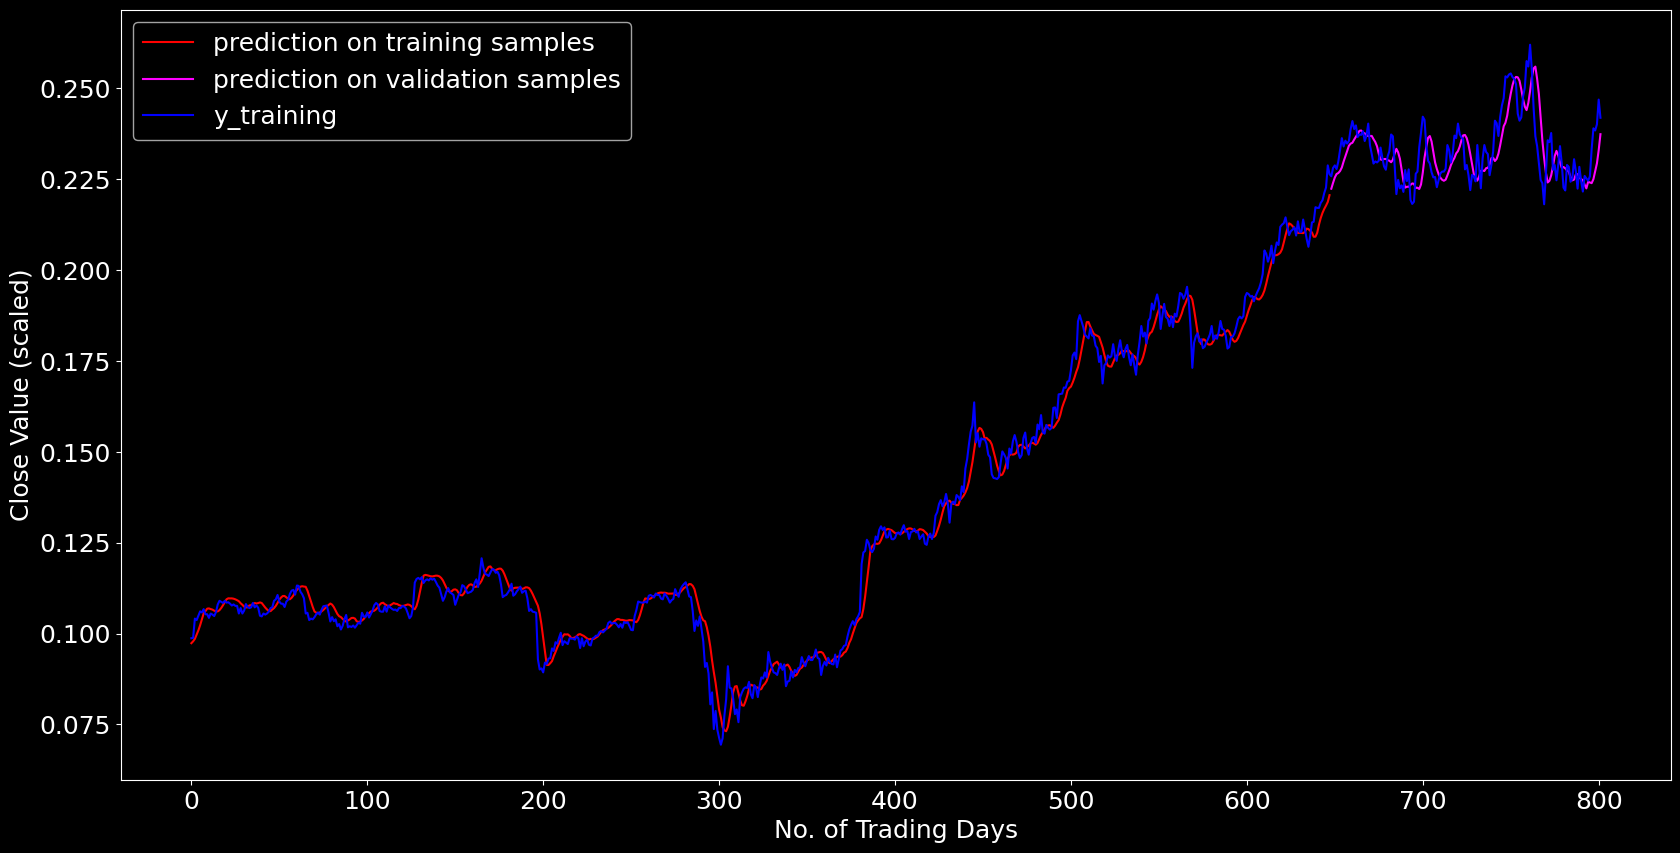

In [ ]:
# Generating predictions on the training set using the trained model
plt.plot(p1[:648],color='red', label='prediction on training samples')
x = np.array(range(648,802))
plt.plot(x,p1[648:],color = 'magenta',label ='prediction on validation samples')
plt.plot(y_train,color='blue', label='y_training')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,10)
#fig.savefig('img/25/mrftrainconv1dlstm.png', dpi=300)
plt.show()

In [ ]:
# Scaling back the predicted and actual values for better visualization
y = y_test * 100
y_pred = p.reshape(200)
y_pred = y_pred * 100

In [ ]:
# Importing mean_absolute_error from scikit-learn
from sklearn.metrics import mean_absolute_error

In [ ]:
# Printing the root mean squared error (RMSE) and mean absolute error (MAE) for training and testing sets
print('Trainscore RMSE \tTrain Mean abs Error \tTestscore Rmse \t Test Mean abs Error')
print('%.9f \t\t %.9f \t\t %.9f \t\t %.9f' % (math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[1]))

Trainscore RMSE 	Train Mean abs Error 	Testscore Rmse 	 Test Mean abs Error
0.004720024 		 0.003313736 		 0.006063087 		 0.004725154


In [ ]:
# Printing the root mean squared error (RMSE) and mean absolute error (MAE) for training and testing sets
print('mean absolute error \t mean absolute percentage error')
print(' %.9f \t\t\t %.9f' % (mean_absolute_error(y,y_pred),(np.mean(np.abs((y - y_pred) / y)) * 100)))

mean absolute error 	 mean absolute percentage error
 0.472515469 			 2.445087632


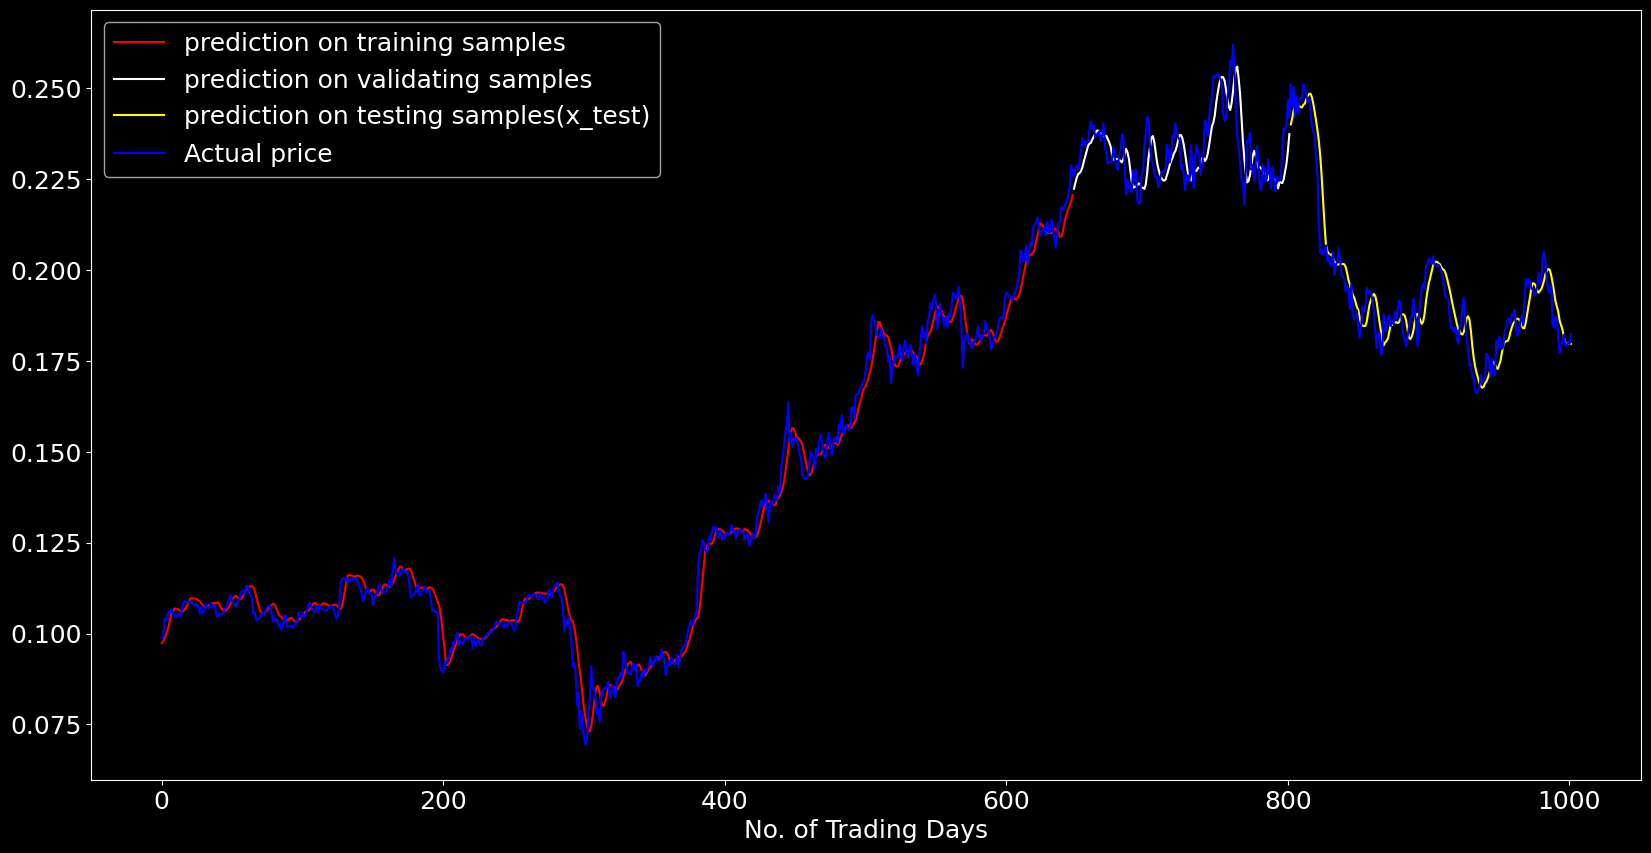

In [ ]:
# Concatenating predicted values for training and testing sets
Y = np.concatenate((y_train,y_test),axis = 0)
P = np.concatenate((p1,p),axis = 0)
#plotting the complete Y set with predicted values on x_train and x_test(variable p1 & p respectively given above)
#for training samples
plt.plot(P[:648],color='red', label='prediction on training samples')
#for validating samples
z = np.array(range(648,802))
plt.plot(z,P[648:802],color = 'white',label ='prediction on validating samples')
#for testing samples
x = np.array(range(802,1002))
plt.plot(x,P[802:],color = 'yellow',label ='prediction on testing samples(x_test)')
plt.xlabel('No. of Trading Days')
plt.plot(Y,color='blue', label='Actual price')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.show()